In [1]:
%matplotlib inline
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import os
from PIL import Image
from tqdm.notebook import tqdm
cuda = torch.device('cuda:0')

In [2]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [3]:
image_dim = 224

def show_sample(sample):
    """
    Displays a sample as they come out of the trainloader.
    """
    
    mask = sample['mask']
    
    masked_im = sample['full_image'].clone()
    masked_im[mask] = 0.0

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(sample['caption'], size=20)
    ax1.imshow(sample['full_image'].permute(1,2,0).numpy().clip(0,1))
    ax2.imshow(masked_im.permute(1,2,0).numpy().clip(0,1))
    ax3.imshow(sample['full_image'][mask].view(3,100,100).permute(1,2,0).numpy().clip(0,1))
    plt.show()

class COCODataset(Dataset):
    def __init__(self, annotations, datadir, transform=None):
        """
        Dataset of obfuscated coco images, with captions.
        
        annotations: load from pickle, akshay's processed annotations
        datadir: Preprocessed data. Contains /originals and /masked
        tranforms: function to be run on each sample
        """
        
        self.datadir = datadir
        self.transform = transform
        self.annotations = annotations
        self.filenames = os.listdir(datadir)
        
        # Since every 5 samples is the same image, we have a one image cache.
        # TODO this may get fucky with shuffle? we can find out later.
        self.last_image = None
        self.last_index = None
        
    def __len__(self):
        return len(self.filenames) * 5
    
    def __getitem__(self, idx):
        """
        Gets images from the dataset.
        
        Each image has 5 replicas, with different captions and sections
        
        Returns: dictionary with blanked out ['image'] and ['caption']
            image: FloatTensor
            caption: string (may later be a list)
        """

        # Load image or retrieve from cache
        
        image_filename = self.filenames[idx // 5]
        image_id = int(image_filename.split(".")[0])
        
        
        if self.last_index is not None and idx // 5 == self.last_index // 5:
            full_image = self.last_image
        else:
            image_filepath = os.path.join(self.datadir, image_filename)
            full_image = Image.open(image_filepath)
            self.last_image = full_image
        
        self.last_index = idx
        full_image = full_image.convert("RGB") # The occasional 1 channel grayscale image is in there.
        full_image = full_image.resize((image_dim, image_dim))

        # Fetch annotation, mask out area
        anno = self.annotations[image_id][idx % 5]
        
        x1 = anno['coord_start'][0]
        y1 = anno['coord_start'][1]
        x2 = x1 + 100
        y2 = y1 + 100
        
        mask = torch.zeros(3, image_dim,image_dim,dtype=torch.bool)
        mask[:,y1:y2,x1:x2] = True

        sample = {
            'caption': anno['caption'],
            'full_image': full_image, # Automatically stacked by the loader
            'image_id':image_id,
            'mask':mask # Automatically stacked by the loader
         }

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [4]:
%%time
annos = pd.read_pickle("../../annotations_train2017.pickle")

# Recommended resnet transforms.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# TODO change masking logic to accomodate this
#resnet_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])
#resnet_transform = transforms.Compose([transforms.Resize((image_dim,image_dim)), transforms.ToTensor(), normalize])
#resnet_transform = transforms.Compose([transforms.ToTensor(), normalize])
resnet_transform = transforms.Compose([transforms.ToTensor()])


def basic_transform_sample(sample):
    """
    A "default" transformer. Applies recommended resnet transforms.
    """
    #sample['masked_image'] = resnet_transform(sample['masked_image'])
    sample['full_image'] = resnet_transform(sample['full_image'])
    return sample

dataset_train = COCODataset(annos, "../../data/train2017", transform=basic_transform_sample)
trainloader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=16) # VERY important to make sure num_workers > 0

CPU times: user 1.55 s, sys: 203 ms, total: 1.75 s
Wall time: 1.75 s


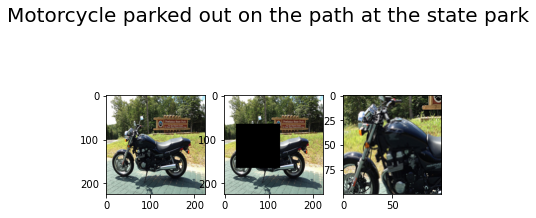

In [5]:
show_sample(dataset_train[0])

In [6]:
import torch
from torch import nn
class ConvModel(nn.Module):
    """
    Convolutional AE
    """
    
    #generator model
    def __init__(self):
        super(ConvModel,self).__init__()

        self.t1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        self.t2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t3=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t4=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t5=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
            
        )
        
        # This is my "Convolutional FC" it doesn't change the size, it just runs a big ass kernel over the thing.
#         self.t6 = nn.Sequential(
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(9,9), stride=1, padding=4),
#             nn.LeakyReLU(),
#             nn.ConvTranspose2d(in_channels=512, out_channels=512,kernel_size=(9,9), stride=1, padding=4)
#         )
        
        self.t7=nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.t8=nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        self.t9=nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.t10=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.t11=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        x=self.t1(x)
        x=self.t2(x)
        x=self.t3(x)
        x=self.t4(x)
        x=self.t5(x)
        #sh = x.shape
        #print(sh)
        #x=self.t6(x)
        #x=x.view(sh)
        x=self.t7(x)
        x=self.t8(x)
        x=self.t9(x)
        x=self.t10(x)
        x=self.t11(x)
        x = (x + 1) / 2
        return x

In [7]:
class Discriminator(nn.Module):
    #discriminator model
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.t1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t4=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.t5=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=(4,4),stride=1,padding=0),
            nn.Flatten(start_dim=1)
        )
        self.t6 = nn.Sequential(
            nn.Linear(121, 121),
            nn.Linear(121, 1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x=self.t1(x)
        x=self.t2(x)
        x=self.t3(x)
        x=self.t4(x)
        x=self.t5(x)
        x=self.t6(x)
        return x

In [8]:
def PSNRLoss(original, inpainted): 
    eps = 1e-11
    mse = torch.mean((original - inpainted)**2)
    psnr = 20 * torch.log10(1/torch.sqrt(mse+eps)) 
    return -psnr

In [9]:
n_epochs = 10 # number of epochs
batch_size = 64 # size of the batches
n_cpu = 8 # number of cpu threads to use during batch generation

# Adam parameters
lr = 0.001 # adam: learning rate
b1 = 0.9 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient

sample_interval = 500 # interval betwen image samples

In [10]:
%%time
# Loss function
mse = torch.nn.MSELoss()
bce = torch.nn.BCELoss()

# Initialize generator and discriminator
coarse = ConvModel()
generator = ConvModel()
discriminator = Discriminator()

coarse.cuda()
generator.cuda()
discriminator.cuda()
mse.cuda()

r_losses = np.asarray([])
d_losses = np.asarray([])
g_losses = np.asarray([])
times = np.asarray([])

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

CPU times: user 989 ms, sys: 610 ms, total: 1.6 s
Wall time: 7.44 s


In [11]:
val_image = "../../data/val2017/000000000632.jpg"
train_image = "../../data/train2017/000000000009.jpg"

def show_checkpoint_repros():
    room = Image.open(val_image) # picture of a room from the validation set.
    caption = "A bedroom with a bookshelf, a window, and a mirror." # I wrote a caption for it
    room = room.convert("RGB")
    room = room.resize((224,224))

    tr = transforms.ToTensor()
    room_t = tr(room)
    x1 = 30
    y1 = 50
    x2 = x1 + 100
    y2 = y1 + 100

    mask = torch.zeros(3, image_dim,image_dim,dtype=torch.bool)
    mask[:,y1:y2,x1:x2] = True
    
    masked = room_t.detach().clone()
    masked[mask] = 0

    tr_im = Image.open(train_image)
    tr_im = tr_im.convert("RGB")
    tr_im = tr_im.resize((224,224))
    tr_im_t = tr(tr_im)
    tr_masked = tr_im_t.detach().clone()
    tr_masked[mask] = 0
    
    with torch.no_grad():
        generator.eval()
        #recon_full = generator(coarse(room_t.unsqueeze(0).cuda()))
        recon_masked = generator(coarse(masked.unsqueeze(0).cuda()))
        recon_tr = generator(coarse(tr_masked.unsqueeze(0).cuda()))

        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,4))
        plt.suptitle(caption)
        ax1.imshow(room_t.permute(1,2,0))
        ax1.set_title("Full - Val")
        ax2.imshow(masked.permute(1,2,0))
        ax2.set_title("Masked - Val")
        ax3.imshow(recon_masked[0].cpu().permute(1,2,0))
        ax3.set_title("Reconstruction - Val")
        ax4.imshow(tr_im_t.permute(1,2,0))
        ax4.set_title("Full - Train")
        ax5.imshow(tr_masked.permute(1,2,0))
        ax5.set_title("Masked - Train")
        ax6.imshow(recon_tr[0].cpu().permute(1,2,0))
        ax6.set_title("Reconstruction - Train")
        plt.show()

In [12]:
# Resume from checkpoint
coarse.load_state_dict(torch.load("../GAN_Inpainting_TA/checkpoints/ConAE_stage2_epoch_13_0.02207687310874462.pth"))
coarse.eval()
#discriminator.load_state_dict(torch.load("./checkpoints/GAN_psnr_discriminator_epoch_5_9.453065285924822e-05.pth"))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
resume = True
if resume:
    generator.load_state_dict(torch.load("./checkpoints/G_temp.pth"))
    discriminator.load_state_dict(torch.load("./checkpoints/D_temp.pth"))
else:
    generator.load_state_dict(torch.load("../GAN_Inpainting_TA/checkpoints/ConAE_stage2_epoch_13_0.02207687310874462.pth"))

BEGIN STAGE 1


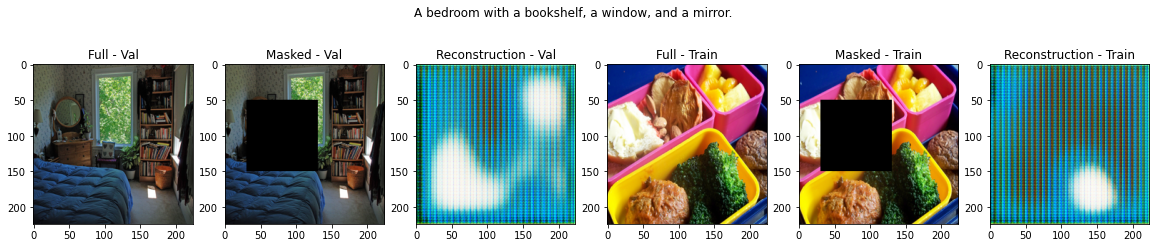

2020-11-07 03:29:47.862159 [Epoch 0/10] [Batch 0/9242] [D loss: 0.107207] [G loss: 6.247200] [Recon Loss: 0.188571]


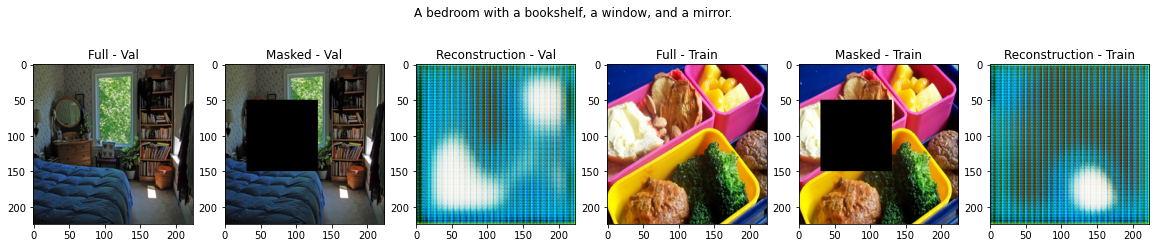

2020-11-07 03:33:35.280065 [Epoch 0/10] [Batch 500/9242] [D loss: 0.055255] [G loss: 6.417177] [Recon Loss: 0.181830]


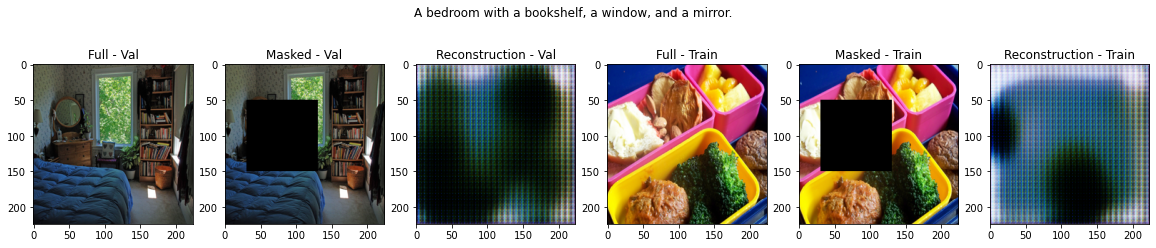

2020-11-07 03:37:23.405276 [Epoch 0/10] [Batch 1000/9242] [D loss: 0.055846] [G loss: 6.860273] [Recon Loss: 0.167801]


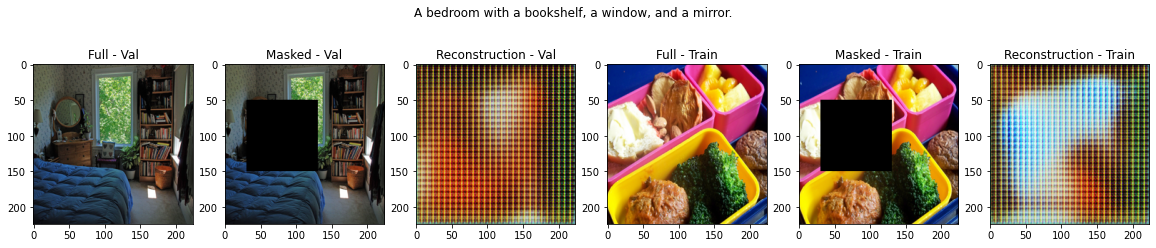

2020-11-07 03:41:09.291090 [Epoch 0/10] [Batch 1500/9242] [D loss: 0.065942] [G loss: 6.327547] [Recon Loss: 0.149661]


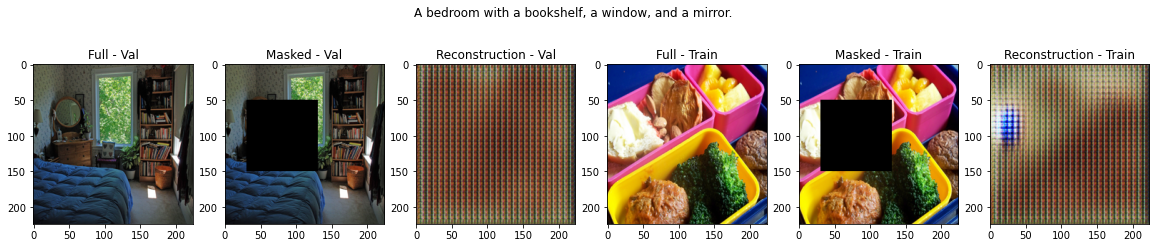

In [ ]:
# ----------
#  Training
# ----------

print("BEGIN STAGE 1")

for epoch in tqdm(range(0, n_epochs)):
    if epoch == 0:
        show_checkpoint_repros()
    for i, batch in enumerate(trainloader):
        generator.train()
        
        full_imgs = batch['full_image'].cuda()
        mask = batch['mask']
        masked_imgs = full_imgs.detach().clone()
        
        masked_imgs[mask] = 0.0

        #if (epoch + i) % 5 == 0:
        optimizer_G.zero_grad()
        
        valid = Variable(Tensor(full_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(masked_imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Generate a batch of images
        coarse_imgs = coarse(masked_imgs)
        gen_imgs = generator(coarse_imgs)

        #if (epoch + i) % 5 == 0:
        #gen_rois = gen_imgs[mask]
        #full_rois = full_imgs[mask]

        recon_loss = mse(gen_imgs, full_imgs)
        g_loss_adv = bce(discriminator(gen_imgs), valid)
        g_loss = .2*recon_loss + .8*g_loss_adv

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        #if (epoch + i) % 3 != 0:
        real_loss = bce(discriminator(full_imgs), valid)
        fake_loss = bce(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(trainloader) + i
        if batches_done % sample_interval == 0:
            d_losses = np.append(d_losses, d_loss.item())
            g_losses = np.append(g_losses, g_loss.item())
            r_losses = np.append(r_losses, recon_loss.item())
            times = np.append(times, time.time())
            print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Recon Loss: %f]" % (epoch, n_epochs, i, len(trainloader), d_losses.mean(), g_losses.mean(), r_losses.mean()) )
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            torch.save(generator.state_dict(), "./checkpoints/G_temp.pth")
            torch.save(discriminator.state_dict(), "./checkpoints/D_temp.pth")
            show_checkpoint_repros()

    torch.save(generator.state_dict(), f"./checkpoints/GAN_Refinement_G_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"./checkpoints/GAN_Refinement_D_{epoch}.pth")

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Checkpoint (500 batches)")
plt.legend()
plt.show()